## Simulating Model

# DGP
$ y_{it} = \alpha_i + \delta_t + \beta \times Treatment_{it} + \epsilon_{it} $

In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(123)

In [140]:
T = 2
N = 5000

# generate N random alphas
alpha = np.random.randn(N) # from a standard normal
alphas = np.tile(alpha, T)

# generate T random deltas
delta = np.random.randn(T)

# define a beta
beta = 0.2

# create treatment vector
half = int(N/2)
treatment_1 = np.ones(half)
treatment_0 = np.zeros(half)
treatment = np.append(treatment_0, treatment_1)
np.random.shuffle(treatment)

treatments = np.tile(treatment, T)

In [141]:
# create a dataframe
df = pd.DataFrame({'alpha':alphas,'treatment':treatments})
period = [[x] * N for x in range(1,T+1)]
df['period'] = np.array(period).reshape(N*T)
df['delta'] = df['period'].apply(lambda row: delta[row-1])

In [142]:
# generate epsilon
df['epsilon'] = 0 * df['alpha'] + 0 * df['treatment'] + np.random.randn(N *T)
# calculate y
df['y'] = df['alpha'] + df['delta'] + beta * df['treatment'] + df['epsilon']

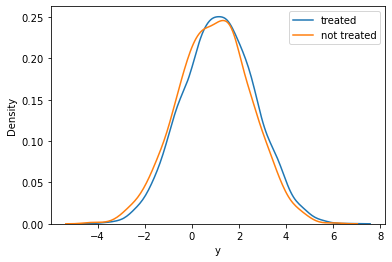

In [143]:
fig, ax = plt.subplots()
sns.kdeplot(df[df.treatment == 1]['y'], ax = ax, label = 'treated')
sns.kdeplot(df[df.treatment == 0]['y'], ax = ax, label = 'not treated')
plt.legend()
plt.show()